# Análise das Vendas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import Markdown as md


PATH = 'C:/Users/cpcle/OneDrive/Documentos/Celso/Python/veneta-dash/data/'
ISBN = PATH + 'Cadastro de Produtos.xlsx'
CADASTRO = PATH + 'Tabela_Veneta_2020.xlsx'
NOTAS = PATH + 'Notas.pkl'
ANO_ATU = '2021'
ANO_ANT = str(int(ANO_ATU)-1)

# Lista dos títulos do PNLD
PNLD = ['CAROLINA - 0991L18606130IL',
        'ANGOLA JANGA - 1132L18606130IL',
        'CUMBE - 1146L18606130IL',
        'Angola Janga - 1132L - e-pub',
        'Carolina - 0991L - e-pub',
        'Cumbe - 1146L - e-pub']

# Agrupamento de Títulos
AGRP_TIT = {'9788595710207': ('9788563137203', 'Cumbe'),
            '9788595710214': ('9788563137036', 'A arte de Voar'),    
            '9788595710399': ('9788563137586', 'Carolina'),
            '9786586691009': ('9788563137562', 'Matadouro de Unicornios'),    
            }

In [2]:
# Funções do relatório
def exclui_excecoes(a):

    return \
        [x for x in a if x not in
            ['Frete',
             'Camiseta Veneta',
             'Livros - REF. 97885631373 - Le Caravage T01 Bresilien',
             'Ilustracao original - LN',
             'Jogo de futebol de botao - LN',
             'Risografia - LN',
             'VIVA A REVOLUCAO! - e-pub']
         ]

def completa_12(a):    
    y=a.tolist()
    y.extend([None for i in range(12)])
    return y[:12]

def formata_numero(col, casas):
     formato = '{:,.' + '{:0n}'.format(casas) + 'f}'

     if isinstance(col, pd.Series):
        return col.map(lambda x: formato.format(x).replace(',', '@').replace('.', ',').replace('@', '.'))
     else:
        return col.applymap(lambda x: formato.format(x).replace(',', '@').replace('.', ',').replace('@', '.'))

In [3]:
# Abre arquivos de Cadastro de Produtos (ISBN e Data de Lançamento)
cad = pd.read_excel(CADASTRO, sheet_name=0,
                    usecols='A,J', dtype={'ISBN': str}, parse_dates=['Lançamento']).dropna()
isbn = pd.read_excel(ISBN, sheet_name=0, usecols='A,D', dtype={
                    'ISBN': str, 'Título Excel': str, 'Título WB': str, 'Centro de Custo': str})\
                    .dropna().set_index(keys=['Título Excel'])

In [4]:
# Relação Títulos Excel / Titulos WB (Agrupamento Edições)

# Títulos da primeira edição
chaves = {i[0] for i in AGRP_TIT.values()}
chaves = isbn.loc[isbn['ISBN'].isin(chaves)].reset_index().set_index('ISBN').to_dict()
chaves = chaves[list(chaves)[0]]

# Monta dicionário de titulos -> segunda edição: primeira edição
tit_edicoes = isbn.loc[isbn['ISBN'].isin(AGRP_TIT), 'ISBN']\
                .reset_index().set_index('ISBN').to_dict()
tit_edicoes = tit_edicoes[list(tit_edicoes)[0]]

# Abre arquivo de Notas e agrupa por Mês e Título
resumo = pd.read_pickle(NOTAS)

# Exclui notas do Pedro
resumo = resumo.loc[~(
    ((resumo['Filial'] == 1) &
     (resumo['NF'].isin(['16400', '16396']))) |
    ((resumo['Filial'] == 2) &
     (resumo['NF'] == '8258'))
)]

resumo = resumo.groupby(
    [pd.Grouper(key='Emissao', freq='MS'),
        'Titulo']).aggregate({'Receita Líquida': 'sum', 'Vendas': 'sum'})
resumo.reset_index(inplace=True)

# Separa valores dos fretes faturados
frete = resumo.loc[resumo['Titulo'] == 'Frete', ['Emissao', 'Receita Líquida']]
frete.columns = ['Emissao', 'Frete']

resumo = resumo.loc[(resumo['Receita Líquida'] != 0) &
                    (resumo['Titulo'] != 'Frete')]

# Exclui Títulos do PNLD
resumo = resumo.loc[~resumo['Titulo'].isin(PNLD)]



In [5]:
# Substitui títulos de segunda edição
key = resumo['Titulo'].isin(tit_edicoes)
resumo.loc[key, 'Titulo'] = resumo.loc[key, 'Titulo'].map(tit_edicoes)
del key

resumo = resumo.groupby(['Emissao', 'Titulo'])\
        .aggregate({'Receita Líquida': 'sum', 'Vendas': 'sum'}).reset_index()

In [6]:
# Coloca ISBN
resumo = resumo.merge(isbn, how='left', left_on='Titulo',
                      right_on='Título Excel')

# Garante que todos Títulos têm ISBN
try:
    assert resumo['ISBN'].isna().sum() == 0

except AssertionError:
    a = resumo.loc[resumo['ISBN'].isna(), 'Titulo'].unique()
    a = exclui_excecoes(a)
    if len(a) > 0:
        print('Falta cadastro do ISBN do título:\n{}'.format(a))
        exit()

# Coloca Data de Lançamento
resumo = resumo.merge(cad, how='left', on='ISBN')

# Garante que todos Títulos têm Data de Lançamento
try:
    assert resumo['Lançamento'].isna().sum() == 0

except AssertionError:
    a = resumo.loc[resumo['Lançamento'].isna(), 'Titulo'].unique()
    a = exclui_excecoes(a)
    if len(a) > 0:
        print('Falta cadastro do Lançamento do título:\n{}'.format(a))

# Calcula número de meses desde o lançamento
resumo['lanc'] = (
    (resumo['Emissao'].dt.year - resumo['Lançamento'].dt.year)*12 +
    (resumo['Emissao'].dt.month - resumo['Lançamento'].dt.month)
)

# Marca o tipo de título - Catálogo ou Lançamento
resumo['6meses'] = resumo['lanc'].map(lambda x: 'Lançamento' if (x < 6)
                                        else 'Catálogo')
del a

In [7]:
# Abre arquivo de Notas e agrupa por Mês e Título
notas = pd.read_pickle(NOTAS)

# Exclui notas do Pedro
notas = notas.loc[~(
                    ((notas['Filial'] == 1) &
                     (notas['NF'].isin(['16400', '16396']))) |
                    ((notas['Filial'] == 2) &
                     (notas['NF'] == '8258'))
                    )]

# Substitui títulos de segunda edição
key = notas['Titulo'].isin(tit_edicoes)
notas.loc[key, 'Titulo'] = notas.loc[key, 'Titulo'].map(tit_edicoes)

# Exclui Frete
notas = notas.loc[notas['Titulo'] != 'Frete']

resumo_com = notas.groupby(
    pd.Grouper(key='Emissao', freq='MS')).\
    aggregate({'Receita Líquida': 'sum'})

resumo_sem = notas[~notas['Titulo'].isin(PNLD)].groupby(
    pd.Grouper(key='Emissao', freq='MS')).\
    aggregate({'Receita Líquida': 'sum'})

faturamento_mensal = pd.concat([resumo_com,
                                resumo_sem,
                                frete.set_index(['Emissao'])], axis=1)
faturamento_mensal.columns = ['com PNLD', 'sem PNLD', 'Frete']
del resumo_com, resumo_sem


In [8]:
# Verifica Lançamento x Primeiro Mês de Vendas
prim_venda = notas.groupby(['Titulo', pd.Grouper(key='Emissao', freq='MS')]).aggregate({'Receita Líquida': 'sum'}).reset_index()
prim_venda = prim_venda[prim_venda['Receita Líquida']!=0.].groupby('Titulo').aggregate({'Emissao': 'min'}).reset_index()
prim_venda = prim_venda.merge(isbn, how='left', left_on='Titulo', right_on='Título Excel').merge(cad, how='left', on='ISBN').dropna(subset=['ISBN'])

testa_prim_venda = prim_venda[prim_venda['Emissao'].dt.strftime('%Y-%m') != prim_venda['Lançamento'].dt.strftime('%Y-%m')]

# Exclui mensagem para BLUES e DESERAMA
testa_prim_venda = testa_prim_venda[~testa_prim_venda['Titulo'].isin(['BLUES', 'DESERAMA'])]

# Garante que o primeiro mês de vendas equivale ao mês do Lançamento
try:
    assert testa_prim_venda.shape[0] == 0
    
except:
    print('Erro no cadastro da data do Lançamento de Livros.\n')    
    print(testa_prim_venda.sort_values('Emissao').to_string(index=False, max_colwidth=25))
    
del cad, isbn, testa_prim_venda


### 1. Evolução Anual da Receita

               com PNLD     sem PNLD     Frete
Emissao                                       
2012           1.171,35     1.171,35      0,00
2013          96.760,09    96.760,09      0,00
2014         549.282,84   549.282,84    386,58
2015       1.239.056,63 1.239.056,63  2.787,53
2016       1.509.774,68 1.509.774,68  3.588,40
2017       1.389.370,95 1.389.370,95  2.572,90
2018       1.631.551,11 1.631.551,11  4.216,41
2019       5.465.495,20 2.233.586,96 18.634,65
2020       3.913.445,11 3.444.736,26 56.848,63
2021       2.039.251,22 2.039.251,22 32.186,03 




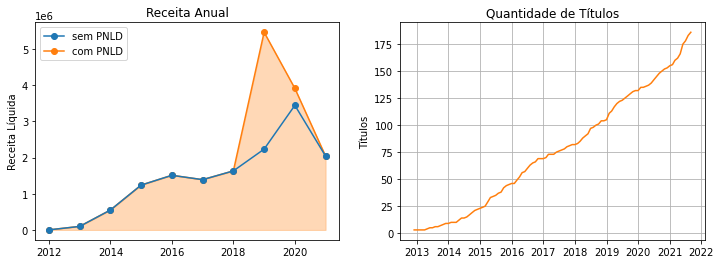

In [9]:
# Calcula faturamento anual
aux = faturamento_mensal.groupby(pd.Grouper(freq='YS')).sum()
print(aux.to_string(float_format= '{:,.2f}'.format).replace(',', '@').replace('.', ',').replace('@', '.').replace('-01-01', 6*' '), '\n\n')

# Evolutivo de Vendas Anuais
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)

x=aux.index.get_level_values(0).year
y=aux['sem PNLD']
ax1.plot(x, y, label='sem PNLD', marker='o')
y=aux['com PNLD']
line = ax1.plot(x, y, label='com PNLD', marker='o', zorder=0)
ax1.fill_between(x, 0, y, alpha=0.3, color=line[0].get_color())

ax1.set_ylabel('Receita Líquida')
ax1.set_title('Receita Anual')
ax1.legend()

aux = prim_venda.groupby(pd.Grouper(key='Emissao', freq='MS')).agg(Lançamentos=('Emissao', 'size'))
aux['Acumulado'] = aux['Lançamentos'].cumsum()

ax2 = fig.add_subplot(1, 2, 2)

y=aux['Acumulado']
ax2.plot(aux.index, y, label='Títulos', marker='', color=line[0].get_color())

ax2.set_ylabel('Títulos')
ax2.set_title('Quantidade de Títulos')
ax2.grid()

plt.show()


### 2. Faturamento Mensal com e sem produtos do PNLD

In [10]:
aux = faturamento_mensal.loc[ANO_ATU]
aux = aux.to_string(float_format= '{:,.2f}'.format).replace(',', '@').replace('.', ',').replace('@', '.').replace('-01 ', 4*' ')
print(aux, '\n\n')
del aux

             com PNLD   sem PNLD     Frete
Emissao                                   
2021-01     93.452,37  93.452,37  1.816,84
2021-02    350.091,44 350.091,44    744,05
2021-03    150.842,25 150.842,25  5.249,30
2021-04    561.787,05 561.787,05 15.269,15
2021-05    130.945,10 130.945,10  1.460,88
2021-06    166.570,82 166.570,82  1.587,82
2021-07    217.498,29 217.498,29  1.697,75
2021-08    163.559,37 163.559,37  1.509,68
2021-09    204.504,53 204.504,53  2.850,56 




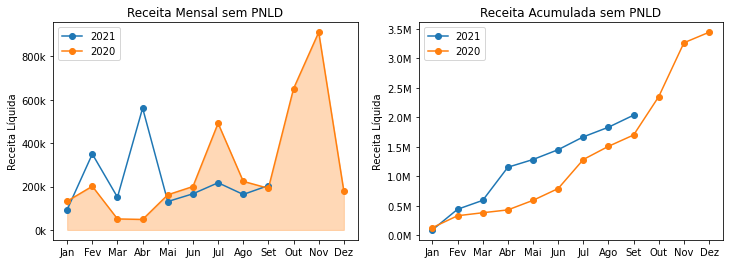

In [11]:
# Evolutivo de Vendas Ano Atual x Ano Anteriol
x=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
   'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)

y=completa_12(faturamento_mensal.loc[ANO_ATU, 'sem PNLD'])
ax1.plot(x, y, label=ANO_ATU, marker='o')
y=faturamento_mensal.loc[ANO_ANT, 'sem PNLD']
line = ax1.plot(x, y, label=ANO_ANT, marker='o')
ax1.fill_between(x, 0, y, alpha=0.3, color=line[0].get_color())

ax1.set_ylabel('Receita Líquida')
ax1.set_title('Receita Mensal sem PNLD')
ax1.yaxis.set_major_formatter(FuncFormatter(
   lambda x, pos: '{:,.0f}k'.format(x/1000).replace(',', '.')
))
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)

y=completa_12(faturamento_mensal.loc[ANO_ATU, 'sem PNLD'].cumsum())
ax2.plot(x, y, label=ANO_ATU, marker='o')
y=faturamento_mensal.loc[ANO_ANT, 'sem PNLD'].cumsum()
ax2.plot(x, y, label=ANO_ANT, marker='o')

ax2.set_ylabel('Receita Líquida')
ax2.set_title('Receita Acumulada sem PNLD')
ax2.yaxis.set_major_formatter(FuncFormatter(
   lambda x, pos: '{:,.1f}M'.format(x/1e6).replace(',', '.')
))
ax2.legend()

plt.show()

In [12]:
del x, y, line

### 3. Quantidade de Exemplares Vendidos desde o início

In [13]:
# Vendas acumuladas por título
x = notas[~notas['Titulo'].isin(PNLD)].groupby('Titulo')\
        .aggregate({'Vendas': sum, 'Receita Líquida': sum})\
        .sort_values('Vendas', ascending=False)

# Imprime total de Exemplares Vendidos
print('\n\nExemplares vendidos desde o início: ', '{:,.0f}'.format(x['Vendas'].sum()).replace(',', '.'), '\n')



Exemplares vendidos desde o início:  423.285 



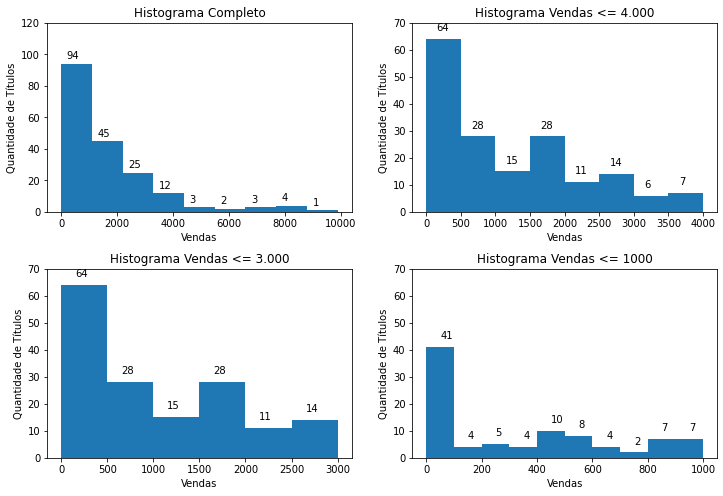

In [14]:
aux = x.head(50).copy()
aux['Vendas'] = formata_numero(aux['Vendas'], 0)
aux['Receita Líquida'] = formata_numero(aux['Receita Líquida'], 2)
aux.reset_index(inplace=True)

aux1 = x.head(20).copy()
aux1['Vendas'] = formata_numero(aux1['Vendas'], 0)

# Histograma de vendas
plt.clf
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)

# Histograma Completo
ax1 = fig.add_subplot(2, 2, 1)

n, val, _ = ax1.hist(x['Vendas'], bins=range(0, 10000, 1100))
# Valores de cada bin
for txt, pos in zip(n, val):
        ax1.text(pos + 200, txt+3, '{:,.0f}'.format(txt))
ax1.set_ylim([0, 120])
ax1.set_title('Histograma Completo')
ax1.set_xlabel('Vendas')
ax1.set_ylabel('Quantidade de Títulos')

x = x[x['Vendas']<=4000]
aux2 = x.head(20).copy()
aux2['Vendas'] = formata_numero(aux2['Vendas'], 0)

# Histograma de Vendas inferior a 4.000 exemplares
ax2 = fig.add_subplot(2, 2, 2)
n, val, _ = ax2.hist(x['Vendas'], bins=8, range=(0, 4000))
# Valores de cada bin
for txt, pos in zip(n, val):
        ax2.text(pos + 150, txt+3, '{:,.0f}'.format(txt))

ax2.set_ylim([0, 70])
ax2.set_title('Histograma Vendas <= 4.000')
ax2.set_xlabel('Vendas')
ax2.set_ylabel('Quantidade de Títulos')

x = x[x['Vendas']<=3000]
aux3 = x.head(20).copy()
aux3['Vendas'] = formata_numero(aux3['Vendas'], 0)

# Histograma de Vendas inferior a 3.000 exemplares
ax3 = fig.add_subplot(2, 2, 3)
n, val, _ = ax3.hist(x['Vendas'], bins=6, range=(0, 3000))
# Valores de cada bin
for txt, pos in zip(n, val):
        ax3.text(pos + 150, txt+3, '{:,.0f}'.format(txt))

ax3.set_ylim([0, 70])
ax3.set_title('Histograma Vendas <= 3.000')
ax3.set_xlabel('Vendas')
ax3.set_ylabel('Quantidade de Títulos')

x = x[x['Vendas']<=1000]
aux4 = x.head(20).copy()
aux4['Vendas'] = formata_numero(aux4['Vendas'], 0)

# Histograma de Vendas inferior a 1.000 exemplares
ax4 = fig.add_subplot(2, 2, 4)
n, val, _ = ax4.hist(x['Vendas'], bins=10, range=(0, 1000))
# Valores de cada bin
for txt, pos in zip(n, val):
        ax4.text(pos + 50, txt+3, '{:,.0f}'.format(txt))

ax4.set_ylim([0, 70])
ax4.set_title('Histograma Vendas <= 1000')
ax4.set_xlabel('Vendas')
ax4.set_ylabel('Quantidade de Títulos')

plt.show()

del n, val, txt, pos


In [15]:
print('\n', aux, '\n\n')

del aux, aux1, aux2, aux3, aux4, x


                                                Titulo  Vendas Receita Líquida
0                                          Do Inferno  32.591    1.818.871,42
1                                        Angola Janga  24.573    1.091.050,30
2                                           O Capital  16.658      275.226,19
3                              A Clavicula de Salomao  15.125      378.274,31
4                             Cumbe - Edicao Ampliada  14.222      409.233,09
5                                  O Caminho do Tarot  13.138      728.410,87
6                                               Ayako   9.238      585.257,03
7                                          Tungstênio   8.502      248.819,12
8                                 Zumbis para Colorir   8.027       53.443,38
9                Thomas Piketty e o Segredo dos Ricos   7.824       95.750,15
10                      DISCURSO SOBRE O COLONIALISMO   7.764      152.286,07
11                                     O Livro da Lei   7.062 

### 4. Receita mensal sem PNLD, dividida por Catálogo e por Lançamento.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;Critério para Catálogo: São títulos de Catálogo aqueles lançados há mais de 6 meses<br>

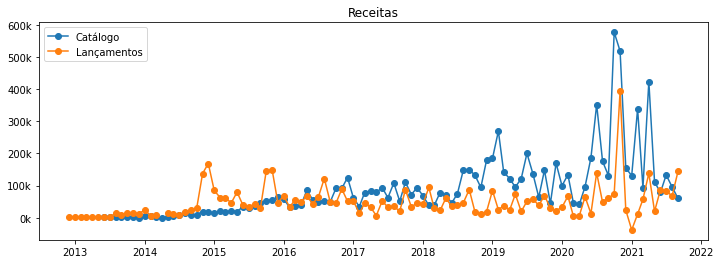

In [16]:
catalogo = resumo.groupby([pd.Grouper(key='Emissao', freq='MS'),
    '6meses']).aggregate({'Receita Líquida': 'sum', 'Titulo': pd.Series.nunique})\
    .reset_index().pivot(index='Emissao', columns='6meses', values=['Receita Líquida', 'Titulo'])

plt.clf
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 1, 1)
y=catalogo[('Receita Líquida', 'Catálogo')]
ax1.plot(catalogo.index, y, label='Catálogo', linestyle='-', marker='o')

y=catalogo[('Receita Líquida', 'Lançamento')]
ax1.plot(catalogo.index, y, label='Lançamentos', linestyle='-', marker='o')
ax1.yaxis.set_major_formatter(FuncFormatter(
   lambda x, pos: '{:,.0f}k'.format(x/1000).replace(',', '.')
))
ax1.set_title('Receitas')
ax1.legend()

plt.show()

In [17]:
aux = catalogo.loc[ANO_ATU]
aux[('Receita Líquida',)] = formata_numero(aux[('Receita Líquida',)], 2)
aux[('Titulo',)] = formata_numero(aux[('Titulo',)], 0)

b = resumo.groupby([pd.Grouper(key='Lançamento', freq='MS')]).aggregate({'Titulo': pd.Series.nunique}).fillna(0)
b = b.loc[ANO_ATU]
aux[('Qtd', 'Lançamentos')] = formata_numero(b, 0)
print(aux, '\n\n')
del b, aux

           Receita Líquida               Titulo                    Qtd
6meses            Catálogo  Lançamento Catálogo Lançamento Lançamentos
Emissao                                                               
2021-01-01      131.056,62  -37.604,25      118         12           2
2021-02-01      338.454,67   11.636,77      117          9           1
2021-03-01       93.386,11   57.456,14      116         12           4
2021-04-01      423.436,72  138.350,33      124         11           2
2021-05-01      110.940,51   20.004,59      117         12           2
2021-06-01       79.102,69   87.468,14      119         19          10
2021-07-01      133.103,80   84.394,49      124         20           3
2021-08-01       96.172,21   67.387,16      124         23           5
2021-09-01       60.345,12  144.159,41      113         24           3 





#### Catálogos e Lançamentos

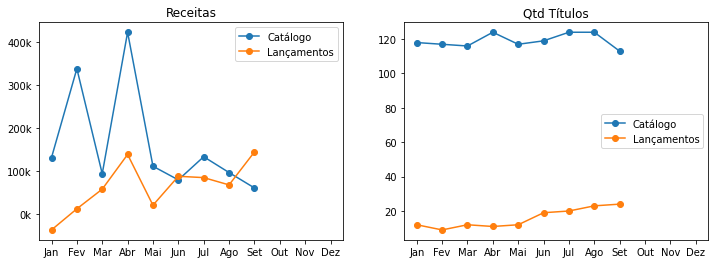

In [18]:
aux = catalogo.loc[ANO_ATU]
x=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
   'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

plt.clf
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
y=completa_12(aux[('Receita Líquida', 'Catálogo')])
ax1.plot(x, y, label='Catálogo', linestyle='-', marker='o')

y=completa_12(aux[('Receita Líquida', 'Lançamento')])
ax1.plot(x, y, label='Lançamentos', linestyle='-', marker='o')
ax1.yaxis.set_major_formatter(FuncFormatter(
   lambda x, pos: '{:,.0f}k'.format(x/1000).replace(',', '.')
))
ax1.set_title('Receitas')
ax1.set_xlim([-0.5, 11.5])
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
y=completa_12(aux[('Titulo', 'Catálogo')])
ax2.plot(x, y, label='Catálogo', linestyle='-', marker='o')
y=completa_12(aux[('Titulo', 'Lançamento')])
ax2.plot(x, y, label='Lançamentos', linestyle='-', marker='o')
ax2.set_title('Qtd Títulos')
ax2.set_xlim([-0.5, 11.5])
ax2.legend()

plt.show()

del ax1, ax2, ax3, ax4, fig

In [19]:
del catalogo, aux

In [20]:
aux = resumo[resumo['Emissao'].dt.year == int(ANO_ATU)].groupby(['6meses', 'Titulo']).aggregate({'Vendas': 'sum', 'Receita Líquida': 'sum'}).sort_values('Receita Líquida', ascending=False)
aux['Vendas'] = formata_numero(aux['Vendas'], 0)
aux['Receita Líquida'] = formata_numero(aux['Receita Líquida'], 2)

In [21]:
md("#### Maiores Vendas de Catálogo {}".format(ANO_ATU))

#### Maiores Vendas de Catálogo 2021

In [22]:
print(aux[aux.index.get_level_values(0) == 'Catálogo'].head(10).reset_index(level=0, drop=True))
print('\n\n')

                                             Vendas Receita Líquida
Titulo                                                             
Angola Janga                                  6.875      294.259,14
O Caminho do Tarot                            1.856      104.872,07
Cumbe - Edicao Ampliada                       2.964       85.138,34
BERLIM                                        1.139       76.055,31
DISCURSO SOBRE O COLONIALISMO                 3.758       72.172,08
O Capital                                     3.201       60.029,55
A Clavicula de Salomao                        1.362       41.719,11
O HOMEM SEM TALENTO                             947       29.928,05
A Mente Suja de Robert Crumb                    507       28.788,54
ENTRE O ENCARDIDO, O BRANCO E O BRANQUISSIMO  1.321       27.576,49





In [23]:
md("#### Maiores Vendas de Lançamentos {}".format(ANO_ATU))

#### Maiores Vendas de Lançamentos 2021

In [24]:
print(aux[aux.index.get_level_values(0) == 'Lançamento'].head(10).reset_index(level=0, drop=True))
print('\n\n')

                        Vendas Receita Líquida
Titulo                                        
PALESTINA                2.360      121.339,55
FUN                      1.540       72.827,15
AS ALMAS DO POVO NEGRO   2.178       60.349,52
CAIXA: KING/BLACK DOGS     678       59.181,72
BLUES                    1.164       43.726,64
LUBA E SUA FAMILIA         760       32.326,25
ESCUTA, FORMOSA MARCIA     584       28.657,38
GUERRA DO DESERTO        1.015       26.900,29
PINTURAS DE GUERRA         621       19.259,10
EU FUI UM GAROTO GORILA    594       16.481,53





### 5. Maiores Clientes

#### Maiores Clientes desde o Início (sem PNLD)

In [25]:
a = notas.copy()

a = a.loc[~a['Titulo'].isin(PNLD), ]

filtro = ((a['CNPJ'].str.len() == 11) &
          (a['CNPJ'] != '01462931855')) | \
         (a['Grupo'] == 'Eventos Veneta')

a.loc[filtro, 'Grupo'] = 'Pessoas Físicas'

maiores_clientes = a.groupby(['Grupo']).aggregate(
    {'Receita Líquida': 'sum'}).sort_values('Receita Líquida', ascending=False)

maiores_clientes = maiores_clientes.head(20)

maiores_clientes['Receita Líquida'] = formata_numero(maiores_clientes['Receita Líquida'], 2)

top_cli = maiores_clientes.index.tolist()

maiores_clientes


,Receita Líquida
Grupo,
Amazon,"5.631.733,83"
Pessoas Físicas,"1.605.464,26"
Saraiva e Siciliano,"1.444.992,29"
Livraria Cultura,"993.821,55"
FNAC,"529.688,85"
Livraria Travessa,"275.415,68"
Comix,"225.517,67"
GM QUALITY COMERCIO LTDA,"218.457,46"
Inovação Distribuidora de Livros Ltda,"199.126,65"


#### 5 maiores clientes em cada ano (sem PNLD)

In [26]:
maiores_clientes = a.groupby([pd.Grouper(key='Emissao', freq='YS'), 'Grupo']).\
    aggregate({'Receita Líquida': 'sum'}).sort_values(by=['Emissao', 'Receita Líquida'], ascending=[True, False])

maiores_clientes.reset_index(inplace=True)

maiores_clientes['Emissao'] = maiores_clientes['Emissao'].dt.year
maiores_clientes.set_index(['Emissao', 'Grupo'], inplace=True)
maiores_clientes = maiores_clientes.groupby('Emissao')
maiores_clientes = maiores_clientes.head(5)
maiores_clientes['Receita Líquida'] = \
    formata_numero(maiores_clientes['Receita Líquida'], 2)

top_cli.extend(maiores_clientes.index.get_level_values(1).tolist())

top_cli = set(top_cli)

maiores_clientes

Receita Líquida
Emissao Grupo                                                        
2012    Comix                                                  677,80
        Itiban                                                 309,10
        Livraria Cultura                                       184,45
        Blooks                                                   0,00
        Gibiteria                                                0,00
2013    Livraria Cultura                                    24.277,75
        FNAC                                                22.861,70
        Saraiva e Siciliano                                 12.813,12
        Livraria da Vila                                     9.401,35
        Comix                                                5.062,00
2014    FNAC                                               191.330,00
        Saraiva e Siciliano                                 99.039,83
        Livraria Cultura                                    83.981,45
        Pessoas Físicas                                     33.117,39
        Livraria Travessa                                   22.049,10
2015    Saraiva e Siciliano                                264.369,53
        FNAC                                               250.351,95
        Livraria Cultura                                   154.134,22
        Pessoas Físicas                                     97.485,09
        Superpedido Comercial S.A                           90.133,08
2016    Amazon                                             546.101,97
        Saraiva e Siciliano                                263.342,53
        Livraria Cultura                                   172.174,65
        Pessoas Físicas                                    116.909,26
        FNAC                                                41.893,30
2017    Amazon                                             477.308,92
        Saraiva e Siciliano                                264.957,13
        Livraria Cultura                                   191.611,52
        Pessoas Físicas                                    112.806,57
        Distribuidora Curitiba de Papeis e livros S/A       39.234,50
2018    Amazon                                             541.353,07
        Saraiva e Siciliano                                358.672,43
        Livraria Cultura                                   189.740,54
        Pessoas Físicas                                    155.720,44
        Distribuidora Curitiba de Papeis e livros S/A       35.485,70
2019    Amazon                                             972.622,96
        Pessoas Físicas                                    210.982,96
        Livraria Cultura                                   161.957,37
        Secretaria Municipal De Educacao                   151.194,87
        Saraiva e Siciliano                                136.243,61
2020    Amazon                                           2.258.541,39
        Pessoas Físicas                                    544.936,91
        Catavento Distribuidora de Livros S/A               67.125,20
        Inovação Distribuidora de Livros Ltda               67.062,90
        A Página Distribuidora de Livros Ltda               48.940,58
2021    Amazon                                             791.740,85
        Pessoas Físicas                                    332.860,37
        GM QUALITY COMERCIO LTDA                           218.457,46
        Inovação Distribuidora de Livros Ltda              112.077,45
        Boa Viagem Distribuidora de Livros Ltda.            83.306,47

#### Evolução dos Maiores Clientes (sem PNLD)

In [27]:
a = a.loc[a['Grupo'].isin(
    top_cli), ['Emissao', 'Grupo', 'Receita Líquida']]

a['Ano'] = a['Emissao'].dt.year

a = a[a['Ano'] >= 2017]

maiores_clientes = a.groupby(['Grupo', 'Ano'], as_index=False). \
    aggregate({'Receita Líquida': 'sum'}).sort_values('Receita Líquida', ascending=False)

maiores_clientes = maiores_clientes.pivot_table(index='Grupo', columns='Ano', values='Receita Líquida', aggfunc=sum, fill_value=0)

# maiores_clientes['Receita Líquida'] = formata_numero(maiores_clientes['Receita Líquida'], 2)

maiores_clientes['Total'] = maiores_clientes.sum(axis=1)

maiores_clientes.sort_values('Total', ascending=False, inplace=True)

for col in maiores_clientes.columns:
    maiores_clientes[col] = formata_numero(maiores_clientes[col], 2)
    
maiores_clientes

Ano,2017,2018,2019,2020,2021,Total
Grupo,,,,,,
Amazon,"477.308,92","541.353,07","972.622,96","2.258.541,39","791.740,85","5.041.567,19"
Pessoas Físicas,"112.806,57","155.720,44","210.982,96","544.936,91","332.860,37","1.357.307,25"
Saraiva e Siciliano,"264.957,13","358.672,43","136.243,61","41.091,46","4.462,65","805.427,28"
Livraria Cultura,"191.611,52","189.740,54","161.957,37","14.783,45","976,15","559.069,03"
GM QUALITY COMERCIO LTDA,"0,00","0,00","0,00","0,00","218.457,46","218.457,46"
Inovação Distribuidora de Livros Ltda,"1.689,10","3.235,60","5.587,95","67.062,90","112.077,45","189.653,00"
Catavento Distribuidora de Livros S/A,"13.914,30","17.610,20","34.978,74","67.125,20","50.465,20","184.093,64"
Livraria Travessa,"24.798,55","28.679,10","53.529,55","40.541,95","34.008,33","181.557,48"
Secretaria Municipal De Educacao,"14.300,65","0,00","151.194,87","-2.803,32","0,00","162.692,20"


In [28]:
#maiores_clientes = notas[(notas['Grupo'].isin(top_cli)) & (notas['Receita Líquida'] != 0)].to_excel('C:\\Users\\cpcle\\Downloads\\top_clientes.xlsx')
   

In [29]:
#! jupyter nbconvert --to html  --no-input analise.ipynb --output-dir=C:\\Users\\cpcle\\OneDrive\\Documentos\\Celso\\Python\\veneta-custo\\html